In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Parameters
num_homes = 5
tank_capacity = 1000  # Each home's tank capacity in liters
daily_water_supply = 2500  # Daily water supply in liters


In [135]:
# Generate sample data for 7 days (1 week)
days = pd.date_range(start="2024-08-01", end="2024-08-07", freq="D")

# Simulate electricity consumption (kWh) for each home
data = {
    "Day": np.repeat(days, num_homes),
    "HomeID": np.tile(range(1, num_homes + 1), len(days)),
    "ElectricityUsage(kWh)": np.random.uniform(10, 50, size=len(days) * num_homes),
}

df = pd.DataFrame(data)

# Function to simulate sensor readings for water level
def simulate_sensor_readings(num_homes, tank_capacity):
    return np.random.randint(0, tank_capacity, size=num_homes)

# Initialize water levels based on simulated sensor readings
initial_water_level = simulate_sensor_readings(num_homes, tank_capacity)
df["CurrentWaterLevel(L)"] = np.tile(initial_water_level, len(days))
df["TankCapacity(L)"] = tank_capacity  # Assign tank capacity to each home
df

,Day,HomeID,ElectricityUsage(kWh),CurrentWaterLevel(L),TankCapacity(L)
0,2024-08-01,1,47.505006,395,1000
1,2024-08-01,2,29.284277,835,1000
2,2024-08-01,3,48.343566,609,1000
3,2024-08-01,4,10.912865,775,1000
4,2024-08-01,5,47.866906,294,1000
5,2024-08-02,1,26.767205,395,1000
6,2024-08-02,2,34.603405,835,1000
7,2024-08-02,3,41.012687,609,1000
8,2024-08-02,4,29.105409,775,1000
9,2024-08-02,5,48.130726,294,1000


In [136]:
# Function to calculate water needed for each home
def calculate_water_needed(df):
    df["WaterNeeded(L)"] = df["TankCapacity(L)"] - df["CurrentWaterLevel(L)"]
    df["WaterNeeded(L)"] = df["WaterNeeded(L)"]
    df["WaterNeeded(L)"] = df["WaterNeeded(L)"]
    return df

In [137]:
# Revised Round-Robin Water Allocation Algorithm with Sensor Integration
def round_robin_allocation(df, daily_water_supply):
    homes = df["HomeID"].unique()
    
    # Initialize PumpedWater column
    df["PumpedWater(L)"] = 0
    
    for day in df["Day"].unique():
        available_water = daily_water_supply
        
        # Update water levels based on sensor readings for the current day
        current_sensor_readings = simulate_sensor_readings(len(homes), tank_capacity)
        df.loc[df["Day"] == day, "CurrentWaterLevel(L)"] = np.tile(current_sensor_readings, len(df[df["Day"] == day]) // len(homes) + 1)[:len(df[df["Day"] == day])]
        
        # Calculate water needed based on updated sensor readings
        df = calculate_water_needed(df)
        
        # Sort homes by water needed (highest first)
        daily_data = df[df["Day"] == day].sort_values(by="WaterNeeded(L)", ascending=False)
        
        while available_water > 0 and not daily_data.empty:
            for _, row in daily_data.iterrows():
                home = row["HomeID"]
                home_water_needed = row["WaterNeeded(L)"]
                allocation = min(available_water, home_water_needed)
                
                # Allocate water and update available water
                df.loc[(df["Day"] == day) & (df["HomeID"] == home), "PumpedWater(L)"] = allocation
                available_water -= allocation
                
                if available_water <= 0:
                    break
            
            # Update current water level after allocation
            df.loc[df["Day"] == day, "CurrentWaterLevel(L)"] = df.loc[df["Day"] == day, "CurrentWaterLevel(L)"] - df.loc[df["Day"] == day, "PumpedWater(L)"]
            # Ensure no negative values for water levels
            df.loc[df["CurrentWaterLevel(L)"] < 0, "CurrentWaterLevel(L)"] = 0
    
    return df

In [138]:
# Apply round-robin allocation
df_allocated = round_robin_allocation(df, daily_water_supply)
df_allocated

C:\Users\harih\AppData\Local\Temp\ipykernel_21580\3865005911.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  15 -262 -442 -566  866]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[df["Day"] == day, "CurrentWaterLevel(L)"] = df.loc[df["Day"] == day, "CurrentWaterLevel(L)"] - df.loc[df["Day"] == day, "PumpedWater(L)"]


,Day,HomeID,ElectricityUsage(kWh),CurrentWaterLevel(L),TankCapacity(L),PumpedWater(L),WaterNeeded(L)
0,2024-08-01,1,47.505006,15,1000,365,985
1,2024-08-01,2,29.284277,0,1000,631,1000
2,2024-08-01,3,48.343566,0,1000,721,1000
3,2024-08-01,4,10.912865,0,1000,783,1000
4,2024-08-01,5,47.866906,866,1000,0,134
5,2024-08-02,1,26.767205,388,1000,204,612
6,2024-08-02,2,34.603405,0,1000,678,1000
7,2024-08-02,3,41.012687,814,1000,62,186
8,2024-08-02,4,29.105409,0,1000,324,1000
9,2024-08-02,5,48.130726,436,1000,188,564


In [139]:
# Energy Efficiency Optimization Algorithm
def energy_efficiency_optimization(df):
    # Scale electricity usage to identify peaks
    scaler = MinMaxScaler()
    df["ScaledElectricityUsage"] = scaler.fit_transform(df[["ElectricityUsage(kWh)"]])
    
    # Identify peak usage periods (scaled value > 0.8)
    df["PeakUsage"] = df["ScaledElectricityUsage"] > 0.8
    
    # Shift peak loads to off-peak periods by reducing usage by 20% during peaks
    df["OptimizedElectricityUsage(kWh)"] = df["ElectricityUsage(kWh)"]
    df.loc[df["PeakUsage"], "OptimizedElectricityUsage(kWh)"] = df["ElectricityUsage(kWh)"] * 0.8
    
    return df

In [140]:
# Apply energy efficiency optimization
df_optimized = energy_efficiency_optimization(df_allocated)
df_optimized

,Day,HomeID,ElectricityUsage(kWh),CurrentWaterLevel(L),TankCapacity(L),PumpedWater(L),WaterNeeded(L),ScaledElectricityUsage,PeakUsage,OptimizedElectricityUsage(kWh)
0,2024-08-01,1,47.505006,15,1000,365,985,0.937822,True,38.004005
1,2024-08-01,2,29.284277,0,1000,631,1000,0.470842,False,29.284277
2,2024-08-01,3,48.343566,0,1000,721,1000,0.959314,True,38.674853
3,2024-08-01,4,10.912865,0,1000,783,1000,0.000000,False,10.912865
4,2024-08-01,5,47.866906,866,1000,0,134,0.947098,True,38.293524
5,2024-08-02,1,26.767205,388,1000,204,612,0.406332,False,26.767205
6,2024-08-02,2,34.603405,0,1000,678,1000,0.607166,False,34.603405
7,2024-08-02,3,41.012687,814,1000,62,186,0.771430,False,41.012687
8,2024-08-02,4,29.105409,0,1000,324,1000,0.466258,False,29.105409
9,2024-08-02,5,48.130726,436,1000,188,564,0.953859,True,38.504581


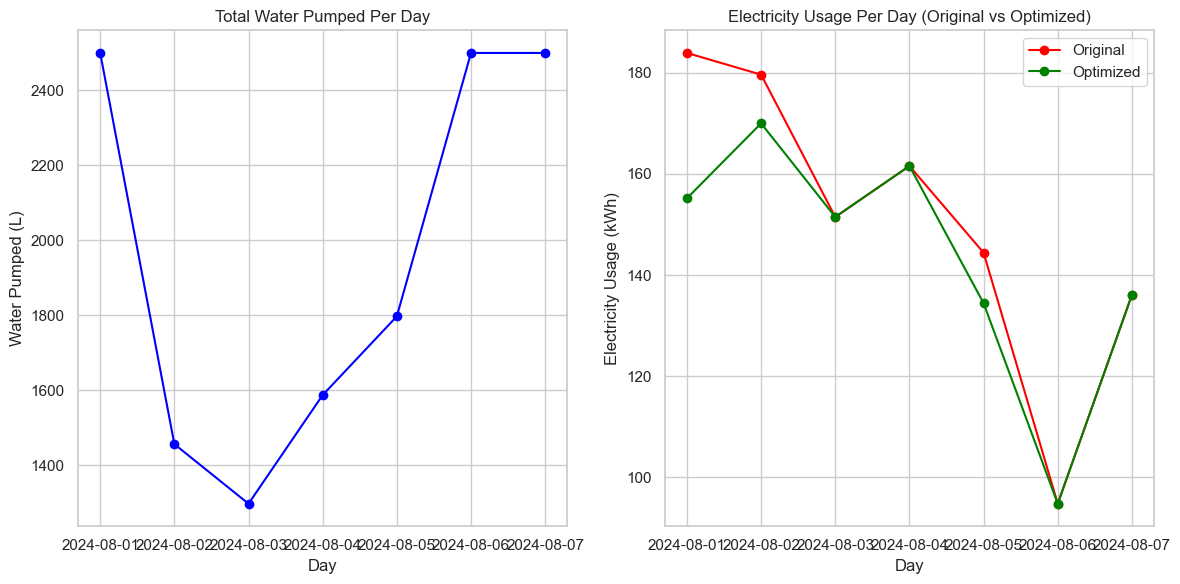

In [141]:
# Summary and Visualization
# Summarize water pumping and electricity usage
allocation_summary = df_optimized.groupby("Day").agg(
    {"PumpedWater(L)": "sum", "ElectricityUsage(kWh)": "sum", "OptimizedElectricityUsage(kWh)": "sum"}
)

# Plot the results
plt.figure(figsize=(12, 6))

# Water Pumping
plt.subplot(1, 2, 1)
plt.plot(allocation_summary.index, allocation_summary["PumpedWater(L)"] , marker='o', color='blue')
plt.title('Total Water Pumped Per Day')
plt.xlabel('Day')
plt.ylabel('Water Pumped (L)')

# Electricity Usage
plt.subplot(1, 2, 2)
plt.plot(allocation_summary.index, allocation_summary["ElectricityUsage(kWh)"] , marker='o', label='Original', color='red')
plt.plot(allocation_summary.index, allocation_summary["OptimizedElectricityUsage(kWh)"] , marker='o', label='Optimized', color='green')
plt.title('Electricity Usage Per Day (Original vs Optimized)')
plt.xlabel('Day')
plt.ylabel('Electricity Usage (kWh)')
plt.legend()

plt.tight_layout()
plt.show()

In [142]:
# Sample data preparation for modeling
# Converting 'Day' to ordinal values for easier modeling
df['Day'] = pd.to_datetime(df['Day']).map(lambda date: date)

# Handle Missing Values
# Check for NaNs in target variable
print("NaNs in target variable:", df['PumpedWater(L)'].isna().sum())

df

NaNs in target variable: 0


,Day,HomeID,ElectricityUsage(kWh),CurrentWaterLevel(L),TankCapacity(L),PumpedWater(L),WaterNeeded(L),ScaledElectricityUsage,PeakUsage,OptimizedElectricityUsage(kWh)
0,2024-08-01,1,47.505006,15,1000,365,985,0.937822,True,38.004005
1,2024-08-01,2,29.284277,0,1000,631,1000,0.470842,False,29.284277
2,2024-08-01,3,48.343566,0,1000,721,1000,0.959314,True,38.674853
3,2024-08-01,4,10.912865,0,1000,783,1000,0.000000,False,10.912865
4,2024-08-01,5,47.866906,866,1000,0,134,0.947098,True,38.293524
5,2024-08-02,1,26.767205,388,1000,204,612,0.406332,False,26.767205
6,2024-08-02,2,34.603405,0,1000,678,1000,0.607166,False,34.603405
7,2024-08-02,3,41.012687,814,1000,62,186,0.771430,False,41.012687
8,2024-08-02,4,29.105409,0,1000,324,1000,0.466258,False,29.105409
9,2024-08-02,5,48.130726,436,1000,188,564,0.953859,True,38.504581


In [143]:
# %%
# Additional Imports for Modeling
from sklearn.metrics import mean_absolute_error

# Prepare features and target variable for modeling
# Using 'Day' as an ordinal feature for modeling
df['DayOrdinal'] = pd.to_datetime(df['Day']).map(lambda date: date.toordinal())

# Features and target variable for water prediction
features = ['DayOrdinal', 'ElectricityUsage(kWh)', 'CurrentWaterLevel(L)']
target = 'PumpedWater(L)'

# Define features and target for training
X = df[features]
y = df[target]

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, random_state=42))
]

# Define meta-model
meta_model = Ridge()

# Create and train stacking ensemble
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X_train, y_train)

# Predict on test set
y_pred = stacking_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

# Predict future water needs
# Create future data for prediction (for example, next 7 days)
future_days = pd.date_range(start="2024-08-08", end="2024-08-14", freq="D")
future_data = {
    "Day": np.repeat(future_days, num_homes),
    "HomeID": np.tile(range(1, num_homes + 1), len(future_days)),
    "ElectricityUsage(kWh)": np.random.uniform(10, 50, size=len(future_days) * num_homes),
    "CurrentWaterLevel(L)": np.tile(np.random.randint(0, tank_capacity, size=num_homes), len(future_days))
}
df_future = pd.DataFrame(future_data)
df_future['DayOrdinal'] = pd.to_datetime(df_future['Day']).map(lambda date: date.toordinal())

# Prepare future data for prediction
X_future = df_future[features]
X_future = imputer.transform(X_future)

# Predict future water needs
df_future['PredictedPumpedWater(L)'] = stacking_model.predict(X_future)

# Display future predictions
df_future


Mean Squared Error: 7594.35
Mean Absolute Error: 66.99


,Day,HomeID,ElectricityUsage(kWh),CurrentWaterLevel(L),DayOrdinal,PredictedPumpedWater(L)
0,2024-08-08,1,49.025815,465,739106,235.487517
1,2024-08-08,2,20.994358,674,739106,180.694011
2,2024-08-08,3,49.789563,235,739106,298.171275
3,2024-08-08,4,29.704138,116,739106,471.931582
4,2024-08-08,5,49.065394,986,739106,78.418341
5,2024-08-09,1,14.855219,465,739107,237.366134
6,2024-08-09,2,11.610261,674,739107,116.946044
7,2024-08-09,3,30.294877,235,739107,279.210199
8,2024-08-09,4,15.722021,116,739107,481.938485
9,2024-08-09,5,13.681750,986,739107,78.935919


In [144]:
# %%
# Additional Imports for Modeling
from sklearn.metrics import mean_absolute_error

# Prepare features and target variable for modeling
# Using 'Day' as an ordinal feature for modeling
df['DayOrdinal'] = pd.to_datetime(df['Day']).map(lambda date: date.toordinal())

# Features and target variable for electricity usage prediction
features = ['DayOrdinal', 'CurrentWaterLevel(L)', 'PumpedWater(L)']
target = 'ElectricityUsage(kWh)'

# Define features and target for training
X = df[features]
y = df[target]

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, random_state=42))
]

# Define meta-model
meta_model = Ridge()

# Create and train stacking ensemble
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X_train, y_train)

# Predict on test set
y_pred = stacking_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

# Predict future electricity usage
# Create future data for prediction (for example, next 7 days)
future_days = pd.date_range(start="2024-08-08", end="2024-08-14", freq="D")
future_data = {
    "Day": np.repeat(future_days, num_homes),
    "HomeID": np.tile(range(1, num_homes + 1), len(future_days)),
    "CurrentWaterLevel(L)": np.tile(np.random.randint(0, tank_capacity, size=num_homes), len(future_days)),
    "PumpedWater(L)": np.tile(np.random.uniform(0, tank_capacity, size=num_homes), len(future_days))
}
df_future = pd.DataFrame(future_data)
df_future['DayOrdinal'] = pd.to_datetime(df_future['Day']).map(lambda date: date.toordinal())

# Prepare future data for prediction
X_future = df_future[features]
X_future = imputer.transform(X_future)

# Predict future electricity usage
df_future['PredictedElectricityUsage(kWh)'] = stacking_model.predict(X_future)

# Display future predictions
df_future



Mean Squared Error: 226.67
Mean Absolute Error: 12.47


,Day,HomeID,CurrentWaterLevel(L),PumpedWater(L),DayOrdinal,PredictedElectricityUsage(kWh)
0,2024-08-08,1,348,848.757109,739106,30.019226
1,2024-08-08,2,935,132.237131,739106,34.399357
2,2024-08-08,3,766,773.191197,739106,35.209427
3,2024-08-08,4,344,590.944381,739106,31.022604
4,2024-08-08,5,824,697.584203,739106,36.194869
5,2024-08-09,1,348,848.757109,739107,30.019226
6,2024-08-09,2,935,132.237131,739107,34.399357
7,2024-08-09,3,766,773.191197,739107,35.209427
8,2024-08-09,4,344,590.944381,739107,31.022604
9,2024-08-09,5,824,697.584203,739107,36.194869
